# RSS Feeds Exploration

This notebook explores RSS feeds as a data source for tech news. We'll:

- Load RSS feed configuration from JSON
- Collect articles from multiple tech RSS feeds
- Parse and clean the data
- Filter articles from the last 24 hours
- Save organized data in JSON format
- Analyze feed performance and content quality

## Setup


In [1]:
import sys
import os
import json
import feedparser
import requests
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from typing import List, Dict, Optional
import time
import re
from tqdm import tqdm

# Load RSS feed configuration
with open('../config/rss_feeds.json', 'r') as f:
    rss_config = json.load(f)

print("✅ RSS feed configuration loaded")
print(f"📊 Total feeds configured: {len(rss_config['feeds'])}")
print(f"⚙️ Settings: {rss_config['settings']}")

# Display enabled feeds
enabled_feeds = [feed for feed in rss_config['feeds'] if feed['enabled']]
print(f"\n📰 Enabled feeds ({len(enabled_feeds)}):")
for feed in enabled_feeds:
    print(f"  • {feed['name']} ({feed['category']})")


✅ RSS feed configuration loaded
📊 Total feeds configured: 61
⚙️ Settings: {'max_age_hours': 24, 'max_items_per_feed': 30, 'timeout_seconds': 30, 'retry_attempts': 3}

📰 Enabled feeds (61):
  • TechCrunch (Tech News)
  • WIRED (Tech News)
  • The Verge (Tech News)
  • Ars Technica (Tech News)
  • Engadget (Tech News)
  • Gizmodo (Tech News)
  • CNET News (Tech News)
  • TechRadar (Tech News)
  • Digital Trends (Tech News)
  • VentureBeat (Tech News)
  • Recode (Vox Technology) (Tech News)
  • GeekWire (Tech News)
  • Mashable (Tech) (Tech News)
  • Hacker News (Top) (Tech News)
  • TechMeme (Tech News)
  • Slashdot (Tech News)
  • Lifehacker (Tech News)
  • MIT Technology Review (Tech News)
  • BBC News - Technology (Tech News)
  • The Guardian - Technology (Tech News)
  • NY Times - Technology (Tech News)
  • Reuters Technology News (Tech News)
  • CNN Technology (Tech News)
  • Business Insider (Tech) (Tech News)
  • HuffPost Tech (Tech News)
  • ZDNet (All Topics) (Tech News)
  • Inf

## RSS Feed Collector Class


In [2]:
class RSSFeedCollector:
    def __init__(self, config):
        self.config = config
        self.settings = config['settings']
        self.feeds = [feed for feed in config['feeds'] if feed['enabled']]
        
    def clean_text(self, text):
        """Clean and normalize text content"""
        if not text:
            return ""
        
        # Remove HTML tags
        text = re.sub(r'<[^>]+>', '', text)
        # Normalize whitespace
        text = re.sub(r'\s+', ' ', text)
        # Strip leading/trailing whitespace
        return text.strip()
    
    def parse_article(self, entry, feed_info):
        """Parse a single RSS entry into standardized format"""
        try:
            # Handle different date formats
            published_date = None
            if hasattr(entry, 'published_parsed') and entry.published_parsed:
                published_date = datetime(*entry.published_parsed[:6])
            elif hasattr(entry, 'updated_parsed') and entry.updated_parsed:
                published_date = datetime(*entry.updated_parsed[:6])
            
            # Clean content
            title = self.clean_text(entry.get('title', ''))
            summary = self.clean_text(entry.get('summary', ''))
            description = self.clean_text(entry.get('description', ''))
            
            # Use description if summary is empty
            if not summary and description:
                summary = description
            
            article = {
                'title': title,
                'url': entry.get('link', ''),
                'summary': summary,
                'content': self.clean_text(entry.get('content', [{}])[0].get('value', '')),
                'published': published_date.isoformat() if published_date else None,
                'author': entry.get('author', ''),
                'feed_name': feed_info['name'],
                'feed_category': feed_info['category'],
                'feed_url': feed_info['url'],
                'tags': [tag.term for tag in entry.get('tags', [])],
                'guid': entry.get('id', entry.get('guid', '')),
                'raw_entry': {
                    'title': entry.get('title', ''),
                    'summary': entry.get('summary', ''),
                    'link': entry.get('link', ''),
                    'published': entry.get('published', ''),
                    'author': entry.get('author', '')
                }
            }
            
            return article
            
        except Exception as e:
            print(f"Error parsing article: {e}")
            return None
    
    def fetch_feed(self, feed_info):
        """Fetch and parse a single RSS feed"""
        try:
            # Parse the RSS feed
            feed = feedparser.parse(feed_info['url'])
            
            if feed.bozo:
                tqdm.write(f"⚠️ Warning: {feed_info['name']} has parsing issues")
            
            articles = []
            cutoff_time = datetime.now() - timedelta(hours=self.settings['max_age_hours'])
            
            for entry in feed.entries[:self.settings['max_items_per_feed']]:
                article = self.parse_article(entry, feed_info)
                if article:
                    # Filter by age
                    if article['published']:
                        article_date = datetime.fromisoformat(article['published'].replace('Z', '+00:00'))
                        if article_date >= cutoff_time:
                            articles.append(article)
                    else:
                        # If no date, include it (might be recent)
                        articles.append(article)
            
            # Use tqdm.write to avoid interfering with progress bar
            tqdm.write(f"✅ {feed_info['name']}: {len(articles)} articles")
            return articles
            
        except Exception as e:
            tqdm.write(f"❌ Error fetching {feed_info['name']}: {e}")
            return []
    
    def collect_all_feeds(self):
        """Collect articles from all enabled feeds"""
        all_articles = []
        feed_stats = []
        
        # Use tqdm for progress tracking
        for feed in tqdm(self.feeds, desc="Fetching RSS feeds", unit="feed"):
            articles = self.fetch_feed(feed)
            all_articles.extend(articles)
            
            feed_stats.append({
                'feed_name': feed['name'],
                'category': feed['category'],
                'articles_count': len(articles),
                'url': feed['url']
            })
            
            # Minimal delay to be respectful to servers
            time.sleep(0.1)  # 100ms delay
        
        return all_articles, feed_stats


## Collect RSS Data


In [3]:
# Initialize collector
collector = RSSFeedCollector(rss_config)

# Collect articles from all feeds
print("🚀 Starting RSS feed collection...")
print(f"⏰ Collecting articles from last {rss_config['settings']['max_age_hours']} hours")
print("=" * 60)

all_articles, feed_stats = collector.collect_all_feeds()

print("=" * 60)
print(f"✅ Collection complete!")
print(f"📊 Total articles collected: {len(all_articles)}")
print(f"📰 Feeds processed: {len(feed_stats)}")

# Display feed statistics
print(f"\n📈 Feed Statistics:")
for stat in feed_stats:
    print(f"  • {stat['feed_name']}: {stat['articles_count']} articles")


🚀 Starting RSS feed collection...
⏰ Collecting articles from last 24 hours


Fetching RSS feeds:   0%|          | 0/61 [00:00<?, ?feed/s]

✅ TechCrunch: 9 articles


Fetching RSS feeds:   2%|▏         | 1/61 [00:00<00:11,  5.20feed/s]

✅ WIRED: 10 articles


Fetching RSS feeds:   5%|▍         | 3/61 [00:00<00:11,  5.03feed/s]

✅ The Verge: 10 articles


Fetching RSS feeds:   7%|▋         | 4/61 [00:00<00:12,  4.67feed/s]

✅ Ars Technica: 0 articles


Fetching RSS feeds:   8%|▊         | 5/61 [00:01<00:23,  2.37feed/s]

⚠️ Warning: Engadget has parsing issues
✅ Engadget: 15 articles


Fetching RSS feeds:  10%|▉         | 6/61 [00:02<00:20,  2.64feed/s]

✅ Gizmodo: 18 articles
✅ CNET News: 25 articles


Fetching RSS feeds:  13%|█▎        | 8/61 [00:03<00:37,  1.40feed/s]

⚠️ Warning: TechRadar has parsing issues
✅ TechRadar: 0 articles


Fetching RSS feeds:  15%|█▍        | 9/61 [00:03<00:30,  1.71feed/s]

⚠️ Warning: Digital Trends has parsing issues
✅ Digital Trends: 0 articles


Fetching RSS feeds:  16%|█▋        | 10/61 [00:04<00:24,  2.12feed/s]

⚠️ Warning: VentureBeat has parsing issues
✅ VentureBeat: 0 articles


Fetching RSS feeds:  18%|█▊        | 11/61 [00:04<00:19,  2.53feed/s]

✅ Recode (Vox Technology): 1 articles


Fetching RSS feeds:  20%|█▉        | 12/61 [00:04<00:18,  2.69feed/s]

✅ GeekWire: 5 articles


Fetching RSS feeds:  21%|██▏       | 13/61 [00:05<00:21,  2.24feed/s]

✅ Mashable (Tech): 25 articles


Fetching RSS feeds:  23%|██▎       | 14/61 [00:05<00:20,  2.29feed/s]

✅ Hacker News (Top): 17 articles


Fetching RSS feeds:  25%|██▍       | 15/61 [00:06<00:21,  2.18feed/s]

⚠️ Warning: TechMeme has parsing issues
✅ TechMeme: 15 articles


Fetching RSS feeds:  26%|██▌       | 16/61 [00:06<00:17,  2.63feed/s]

✅ Slashdot: 15 articles


Fetching RSS feeds:  28%|██▊       | 17/61 [00:07<00:18,  2.33feed/s]

✅ Lifehacker: 0 articles
✅ MIT Technology Review: 0 articles


Fetching RSS feeds:  31%|███       | 19/61 [00:07<00:15,  2.73feed/s]

✅ BBC News - Technology: 0 articles


Fetching RSS feeds:  33%|███▎      | 20/61 [00:07<00:13,  3.12feed/s]

✅ The Guardian - Technology: 4 articles
✅ NY Times - Technology: 3 articles


Fetching RSS feeds:  36%|███▌      | 22/61 [00:08<00:08,  4.35feed/s]

⚠️ Warning: Reuters Technology News has parsing issues
✅ Reuters Technology News: 0 articles


Fetching RSS feeds:  38%|███▊      | 23/61 [00:08<00:10,  3.48feed/s]

✅ CNN Technology: 20 articles


Fetching RSS feeds:  39%|███▉      | 24/61 [00:08<00:10,  3.39feed/s]

✅ Business Insider (Tech): 20 articles


Fetching RSS feeds:  41%|████      | 25/61 [00:09<00:10,  3.31feed/s]

✅ HuffPost Tech: 0 articles


Fetching RSS feeds:  43%|████▎     | 26/61 [00:09<00:10,  3.41feed/s]

✅ ZDNet (All Topics): 5 articles


Fetching RSS feeds:  44%|████▍     | 27/61 [00:09<00:12,  2.72feed/s]

⚠️ Warning: InfoWorld has parsing issues
✅ InfoWorld: 0 articles


Fetching RSS feeds:  46%|████▌     | 28/61 [00:10<00:14,  2.35feed/s]

⚠️ Warning: Computerworld has parsing issues
✅ Computerworld: 0 articles


Fetching RSS feeds:  48%|████▊     | 29/61 [00:10<00:13,  2.39feed/s]

✅ OpenAI Blog: 0 articles


Fetching RSS feeds:  49%|████▉     | 30/61 [00:11<00:12,  2.54feed/s]

✅ Google AI Blog (Research): 0 articles


Fetching RSS feeds:  51%|█████     | 31/61 [00:11<00:14,  2.02feed/s]

✅ DeepMind Blog: 0 articles


Fetching RSS feeds:  52%|█████▏    | 32/61 [00:12<00:14,  1.96feed/s]

✅ BAIR (Berkeley AI Research) Blog: 0 articles
✅ Machine Learning Mastery: 0 articles


Fetching RSS feeds:  56%|█████▌    | 34/61 [00:16<00:36,  1.36s/feed]

✅ MarkTechPost (AI News): 5 articles


Fetching RSS feeds:  57%|█████▋    | 35/61 [00:18<00:43,  1.68s/feed]

✅ Analytics Vidhya: 2 articles
✅ KDnuggets: 0 articles


Fetching RSS feeds:  61%|██████    | 37/61 [00:19<00:25,  1.06s/feed]

✅ Towards Data Science: 3 articles


Fetching RSS feeds:  62%|██████▏   | 38/61 [00:19<00:19,  1.16feed/s]

✅ Datanami: 0 articles


Fetching RSS feeds:  64%|██████▍   | 39/61 [00:20<00:15,  1.39feed/s]

✅ Kaggle Blog: 0 articles


Fetching RSS feeds:  66%|██████▌   | 40/61 [00:20<00:13,  1.58feed/s]

✅ AWS News Blog: 0 articles


Fetching RSS feeds:  67%|██████▋   | 41/61 [00:21<00:10,  1.96feed/s]

✅ All Things Distributed (AWS CTO): 0 articles


Fetching RSS feeds:  69%|██████▉   | 42/61 [00:21<00:08,  2.23feed/s]

✅ Microsoft Azure Blog: 0 articles


Fetching RSS feeds:  70%|███████   | 43/61 [00:23<00:14,  1.21feed/s]

✅ Google Cloud Blog: 0 articles


Fetching RSS feeds:  72%|███████▏  | 44/61 [00:24<00:18,  1.07s/feed]

✅ CloudTech News: 0 articles


Fetching RSS feeds:  74%|███████▍  | 45/61 [00:25<00:16,  1.01s/feed]

✅ CloudTweaks: 0 articles


Fetching RSS feeds:  75%|███████▌  | 46/61 [00:25<00:11,  1.28feed/s]

✅ TechRepublic (Cloud): 0 articles


Fetching RSS feeds:  77%|███████▋  | 47/61 [00:26<00:08,  1.56feed/s]

⚠️ Warning: IBM Cloud Blog has parsing issues
✅ IBM Cloud Blog: 0 articles


Fetching RSS feeds:  79%|███████▊  | 48/61 [00:27<00:10,  1.26feed/s]

⚠️ Warning: AnandTech has parsing issues
✅ AnandTech: 0 articles


Fetching RSS feeds:  80%|████████  | 49/61 [00:27<00:08,  1.41feed/s]

✅ Tom's Hardware: 17 articles


Fetching RSS feeds:  82%|████████▏ | 50/61 [00:28<00:06,  1.74feed/s]

✅ 9to5Mac: 13 articles


Fetching RSS feeds:  84%|████████▎ | 51/61 [00:28<00:05,  1.92feed/s]

✅ Android Authority: 16 articles
✅ ExtremeTech: 0 articles


Fetching RSS feeds:  87%|████████▋ | 53/61 [00:29<00:04,  1.76feed/s]

✅ NVIDIA Blog: 0 articles


Fetching RSS feeds:  89%|████████▊ | 54/61 [00:29<00:03,  2.04feed/s]

✅ Official Microsoft Blog: 0 articles
✅ Apple Newsroom: 0 articles


Fetching RSS feeds:  92%|█████████▏| 56/61 [00:30<00:01,  2.87feed/s]

✅ Google (The Keyword): 0 articles


Fetching RSS feeds:  93%|█████████▎| 57/61 [00:30<00:01,  3.23feed/s]

✅ Facebook Newsroom (Meta): 0 articles
✅ Meta Engineering Blog: 0 articles


Fetching RSS feeds:  97%|█████████▋| 59/61 [00:31<00:01,  1.87feed/s]

✅ Meta Research Blog: 10 articles
✅ Stratechery (Ben Thompson): 0 articles


Fetching RSS feeds: 100%|██████████| 61/61 [00:32<00:00,  1.88feed/s]

✅ Daring Fireball: 1 articles
✅ Collection complete!
📊 Total articles collected: 284
📰 Feeds processed: 61

📈 Feed Statistics:
  • TechCrunch: 9 articles
  • WIRED: 10 articles
  • The Verge: 10 articles
  • Ars Technica: 0 articles
  • Engadget: 15 articles
  • Gizmodo: 18 articles
  • CNET News: 25 articles
  • TechRadar: 0 articles
  • Digital Trends: 0 articles
  • VentureBeat: 0 articles
  • Recode (Vox Technology): 1 articles
  • GeekWire: 5 articles
  • Mashable (Tech): 25 articles
  • Hacker News (Top): 17 articles
  • TechMeme: 15 articles
  • Slashdot: 15 articles
  • Lifehacker: 0 articles
  • MIT Technology Review: 0 articles
  • BBC News - Technology: 0 articles
  • The Guardian - Technology: 4 articles
  • NY Times - Technology: 3 articles
  • Reuters Technology News: 0 articles
  • CNN Technology: 20 articles
  • Business Insider (Tech): 20 articles
  • HuffPost Tech: 0 articles
  • ZDNet (All Topics): 5 articles
  • InfoWorld: 0 articles
  • Computerworld: 0 articles
  

## Analyze and Save Data


In [4]:
# Create data directory
os.makedirs('../data/rss', exist_ok=True)

# Convert to DataFrame for analysis
df = pd.DataFrame(all_articles)

if len(df) > 0:
    print(f"📊 Data Analysis:")
    print(f"   Total articles: {len(df)}")
    print(f"   Unique feeds: {df['feed_name'].nunique()}")
    print(f"   Categories: {df['feed_category'].unique().tolist()}")
    print(f"   Date range: {df['published'].min()} to {df['published'].max()}")
    
    # Articles by category
    category_counts = df['feed_category'].value_counts()
    print(f"\n📈 Articles by Category:")
    for category, count in category_counts.items():
        print(f"   {category}: {count} articles")
    
    # Articles by feed
    feed_counts = df['feed_name'].value_counts()
    print(f"\n📰 Articles by Feed:")
    for feed, count in feed_counts.head(10).items():
        print(f"   {feed}: {count} articles")
    
    # Create comprehensive data structure with all information
    comprehensive_data = {
        'metadata': {
            'collection_date': datetime.now().isoformat(),
            'total_articles': len(df),
            'feeds_processed': len(feed_stats),
            'categories': category_counts.to_dict(),
            'feed_stats': feed_stats,
            'settings': rss_config['settings'],
            'data_structure': {
                'fields': list(df.columns),
                'format': 'JSON',
                'encoding': 'UTF-8'
            }
        },
        'articles': df.to_dict('records'),
        'articles_by_category': {
            category: df[df['feed_category'] == category].to_dict('records')
            for category in df['feed_category'].unique()
        },
        'articles_by_feed': {
            feed_name: df[df['feed_name'] == feed_name].to_dict('records')
            for feed_name in df['feed_name'].unique()
        }
    }
    
    # Save everything in a single comprehensive JSON file
    comprehensive_path = '../data/rss/rss_data.json'
    with open(comprehensive_path, 'w') as f:
        json.dump(comprehensive_data, f, indent=2)
    
    print(f"\n💾 Saved comprehensive data to {comprehensive_path}")
    print(f"   📊 Total articles: {len(df)}")
    print(f"   📰 Feeds: {len(feed_stats)}")
    print(f"   🏷️ Categories: {len(df['feed_category'].unique())}")
    print(f"   📁 File size: {os.path.getsize(comprehensive_path) / 1024:.1f} KB")
    
else:
    print("❌ No articles collected")


📊 Data Analysis:
   Total articles: 284
   Unique feeds: 25
   Categories: ['Tech News', 'AI/ML', 'Data Science', 'Hardware/Gadgets', 'Big Tech', 'Tech Blog']


TypeError: '<=' not supported between instances of 'str' and 'float'

In [6]:
# FIXED VERSION: Run this instead of the problematic cell above
print("🔧 FIXED: Data Analysis with Proper Date Handling")
print("=" * 50)

# Convert to DataFrame for analysis
df = pd.DataFrame(all_articles)

if len(df) > 0:
    print(f"📊 Data Analysis:")
    print(f"   Total articles: {len(df)}")
    print(f"   Unique feeds: {df['feed_name'].nunique()}")
    print(f"   Categories: {df['feed_category'].unique().tolist()}")
    
    # Handle date range with proper error handling
    try:
        # Convert published column to datetime, handling mixed types
        df['published_parsed'] = pd.to_datetime(df['published'], errors='coerce')
        valid_dates = df['published_parsed'].dropna()
        if len(valid_dates) > 0:
            print(f"   Date range: {valid_dates.min()} to {valid_dates.max()}")
            print(f"   Valid dates: {len(valid_dates)}/{len(df)} articles")
        else:
            print(f"   Date range: No valid dates found")
    except Exception as e:
        print(f"   Date range: Error parsing dates - {e}")
    
    # Articles by category
    category_counts = df['feed_category'].value_counts()
    print(f"\n📈 Articles by Category:")
    for category, count in category_counts.items():
        print(f"   {category}: {count} articles")
    
    # Articles by feed
    feed_counts = df['feed_name'].value_counts()
    print(f"\n📰 Top 10 Feeds:")
    for feed, count in feed_counts.head(10).items():
        print(f"   {feed}: {count} articles")
        
    # Save comprehensive data
    print(f"\n💾 Saving comprehensive data...")
    
    # Create comprehensive data structure with JSON-serializable data
    # Convert DataFrame to JSON-serializable format
    def make_json_serializable(obj):
        """Convert pandas objects to JSON-serializable format"""
        if hasattr(obj, 'isoformat'):  # datetime objects
            return obj.isoformat()
        elif hasattr(obj, 'item'):  # numpy scalars
            return obj.item()
        elif isinstance(obj, (list, tuple)):
            return [make_json_serializable(item) for item in obj]
        elif isinstance(obj, dict):
            return {key: make_json_serializable(value) for key, value in obj.items()}
        else:
            return obj
    
    # Convert DataFrame to records, handling non-serializable objects
    articles_records = []
    for _, row in df.iterrows():
        article_dict = {}
        for col, value in row.items():
            article_dict[col] = make_json_serializable(value)
        articles_records.append(article_dict)
    
    comprehensive_data = {
        'metadata': {
            'collection_date': datetime.now().isoformat(),
            'total_articles': len(df),
            'feeds_processed': len(feed_stats),
            'categories': category_counts.to_dict(),
            'feed_stats': feed_stats,
            'settings': rss_config['settings']
        },
        'articles': articles_records,
        'articles_by_category': {
            category: [article for article in articles_records if article['feed_category'] == category]
            for category in df['feed_category'].unique()
        },
        'articles_by_feed': {
            feed_name: [article for article in articles_records if article['feed_name'] == feed_name]
            for feed_name in df['feed_name'].unique()
        }
    }
    
    # Save comprehensive data
    comprehensive_path = '../data/rss/rss_data.json'
    with open(comprehensive_path, 'w') as f:
        json.dump(comprehensive_data, f, indent=2)
    
    print(f"💾 Saved comprehensive data to {comprehensive_path}")
    print(f"   📊 Total articles: {len(df)}")
    print(f"   📰 Feeds: {len(feed_stats)}")
    print(f"   🏷️ Categories: {len(df['feed_category'].unique())}")
    print(f"   📁 File size: {os.path.getsize(comprehensive_path) / 1024:.1f} KB")
        
else:
    print("❌ No articles collected")


🔧 FIXED: Data Analysis with Proper Date Handling
📊 Data Analysis:
   Total articles: 284
   Unique feeds: 25
   Categories: ['Tech News', 'AI/ML', 'Data Science', 'Hardware/Gadgets', 'Big Tech', 'Tech Blog']
   Date range: 2025-09-20 11:48:14 to 2025-09-21 15:40:00
   Valid dates: 254/284 articles

📈 Articles by Category:
   Tech News: 217 articles
   Hardware/Gadgets: 46 articles
   Big Tech: 10 articles
   AI/ML: 5 articles
   Data Science: 5 articles
   Tech Blog: 1 articles

📰 Top 10 Feeds:
   CNET News: 25 articles
   Mashable (Tech): 25 articles
   Business Insider (Tech): 20 articles
   CNN Technology: 20 articles
   Gizmodo: 18 articles
   Hacker News (Top): 17 articles
   Tom's Hardware: 17 articles
   Android Authority: 16 articles
   Slashdot: 15 articles
   Engadget: 15 articles

💾 Saving comprehensive data...
💾 Saved comprehensive data to ../data/rss/rss_data.json
   📊 Total articles: 284
   📰 Feeds: 61
   🏷️ Categories: 6
   📁 File size: 2763.2 KB


## Visualize Data


💾 Saved analysis plot to ../data/rss/rss_analysis.png


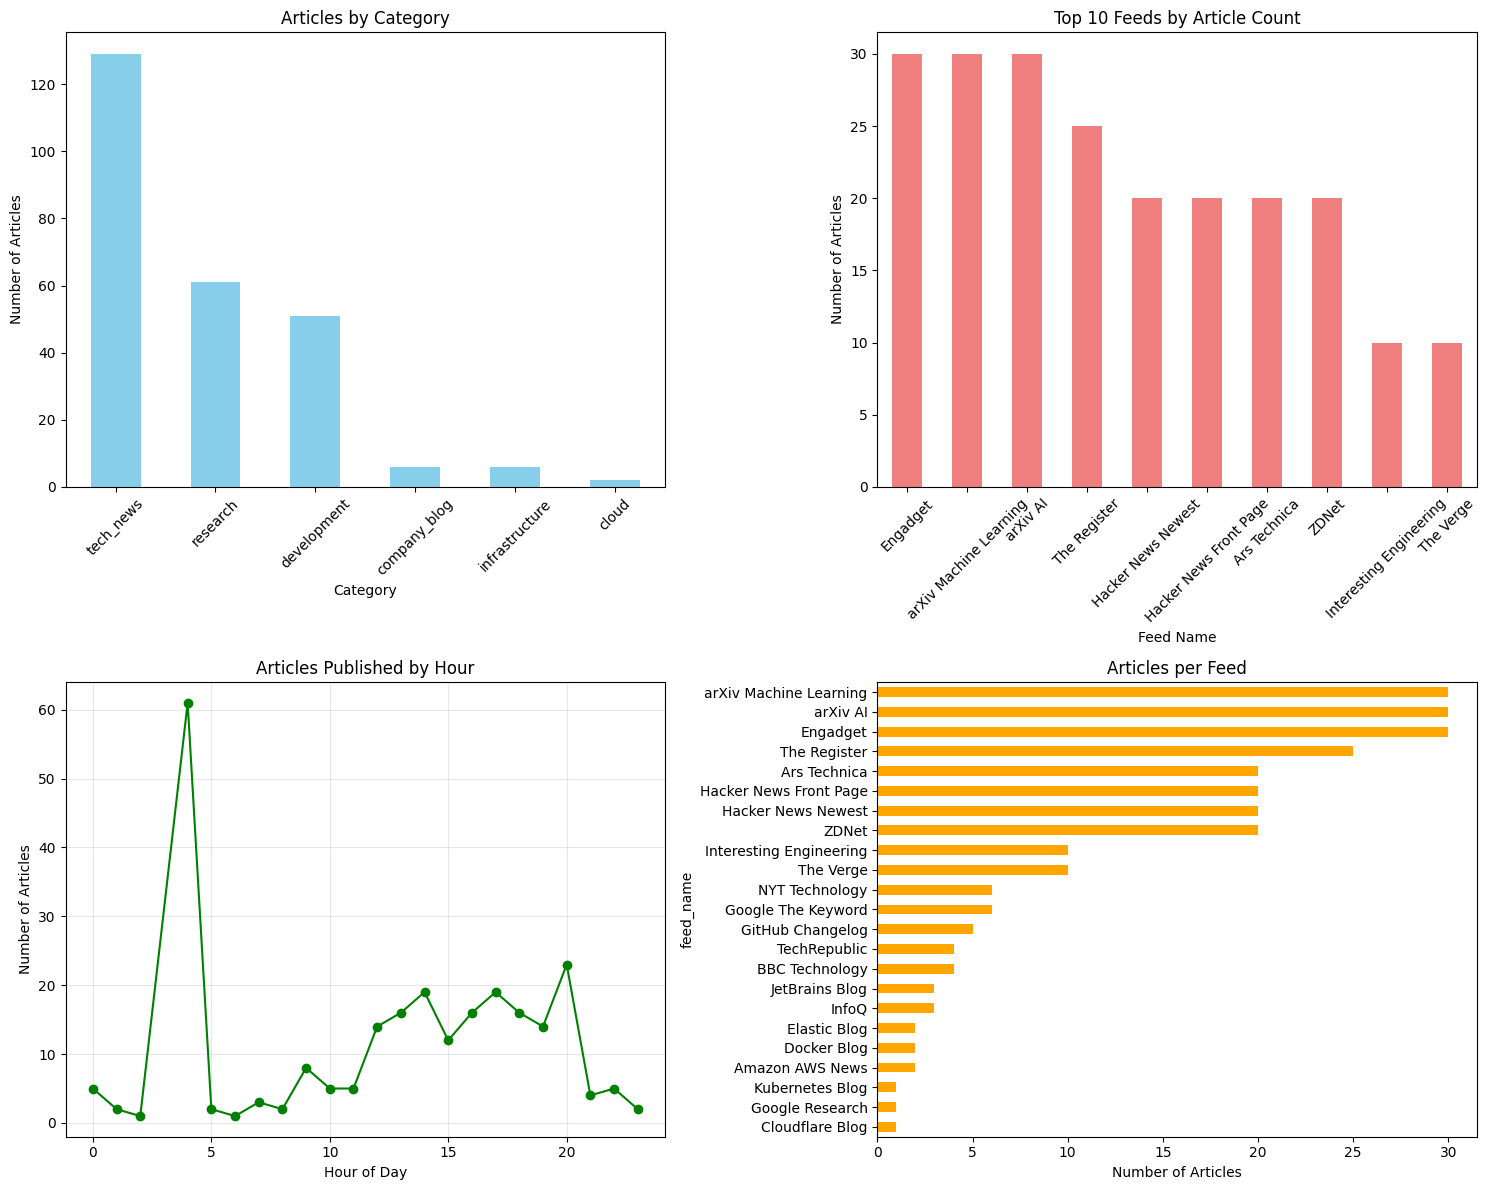


📰 Sample Articles:

1. Find out what’s new in the Gemini app in September’s Gemini Drop.
   Feed: Google The Keyword (company_blog)
   Published: 2025-09-19T16:00:00
   Summary: Gemini Drops is our new monthly update on how to get the most out of the Gemini app....
   URL: https://blog.google/products/gemini/gemini-drop-september-2025/

2. 3 ways to use photo-to-video in Gemini
   Feed: Google The Keyword (company_blog)
   Published: 2025-09-19T16:00:00
   Summary: A collage of images including a still photo of a dinosaur skeleton, then the animated version create...
   URL: https://blog.google/products/gemini/gemini-photo-to-video-tips/

3. How the U.S. Patent and Trademark Office can help America maintain its AI leadership
   Feed: Google The Keyword (company_blog)
   Published: 2025-09-19T13:30:00
   Summary: Stylized US map with connected dots, lightbulb, three bars, three toggle switches, orange block with...
   URL: https://blog.google/outreach-initiatives/public-policy/uspto-ai

In [ ]:
if len(df) > 0:
    # Create visualizations
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
    
    # 1. Articles by Category
    category_counts.plot(kind='bar', ax=ax1, color='skyblue')
    ax1.set_title('Articles by Category')
    ax1.set_xlabel('Category')
    ax1.set_ylabel('Number of Articles')
    ax1.tick_params(axis='x', rotation=45)
    
    # 2. Top 10 Feeds
    feed_counts.head(10).plot(kind='bar', ax=ax2, color='lightcoral')
    ax2.set_title('Top 10 Feeds by Article Count')
    ax2.set_xlabel('Feed Name')
    ax2.set_ylabel('Number of Articles')
    ax2.tick_params(axis='x', rotation=45)
    
    # 3. Articles by Hour (if we have time data)
    if 'published' in df.columns and df['published'].notna().any():
        df['published_dt'] = pd.to_datetime(df['published'])
        df['hour'] = df['published_dt'].dt.hour
        hourly_counts = df['hour'].value_counts().sort_index()
        hourly_counts.plot(kind='line', ax=ax3, marker='o', color='green')
        ax3.set_title('Articles Published by Hour')
        ax3.set_xlabel('Hour of Day')
        ax3.set_ylabel('Number of Articles')
        ax3.grid(True, alpha=0.3)
    
    # 4. Feed Performance (articles per feed)
    feed_performance = df.groupby('feed_name').size().sort_values(ascending=True)
    feed_performance.plot(kind='barh', ax=ax4, color='orange')
    ax4.set_title('Articles per Feed')
    ax4.set_xlabel('Number of Articles')
    
    plt.tight_layout()
    
    # Save the plot
    plt.savefig('../data/rss/rss_analysis.png', dpi=300, bbox_inches='tight')
    print("💾 Saved analysis plot to ../data/rss/rss_analysis.png")
    
    plt.show()
    
    # Display sample articles
    print(f"\n📰 Sample Articles:")
    for i, (_, article) in enumerate(df.head(3).iterrows(), 1):
        print(f"\n{i}. {article['title']}")
        print(f"   Feed: {article['feed_name']} ({article['feed_category']})")
        print(f"   Published: {article['published']}")
        print(f"   Summary: {article['summary'][:100]}...")
        print(f"   URL: {article['url']}")
else:
    print("❌ No data to visualize")
